# 1. Import library

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from tqdm import tqdm

# 2. Setup directory

In [2]:
train_dir = "dataset/TrashType_Image_Dataset/train"
val_dir = "dataset/TrashType_Image_Dataset/val"


# 3. Class mapping

In [3]:
cat_dict = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
print(cat_dict)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


# 4. Data transformation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# 5. Dataset and Dataloader

In [5]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 2377, 'val': 150}


# 6. Device setup

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



# 7. Load pretrained model & modify classifier

In [7]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device)

/home/syahputra/miniconda3/envs/yolo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syahputra/miniconda3/envs/yolo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 8. Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 9. Training function with validation

In [9]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_acc = 0.0
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(num_epochs):
        print("="*60)
        print(f"🔁 Epoch {epoch+1} of {num_epochs}")
        print("="*60)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc.item())
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.item())

                # Save best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), 'best_model.pth')

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    print("Training complete. Best val acc: {:.4f}".format(best_acc))
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

# 10. Train the model

In [10]:
train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=50)

🔁 Epoch 1 of 50


100%|██████████| 75/75 [00:10<00:00,  7.23it/s]


train Loss: 0.6490 Acc: 0.7796


100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


val Loss: 0.3882 Acc: 0.8533
🔁 Epoch 2 of 50


100%|██████████| 75/75 [00:10<00:00,  7.42it/s]


train Loss: 0.1962 Acc: 0.9403


100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


val Loss: 0.2712 Acc: 0.8933
🔁 Epoch 3 of 50


100%|██████████| 75/75 [00:10<00:00,  7.40it/s]


train Loss: 0.0874 Acc: 0.9798


100%|██████████| 5/5 [00:00<00:00, 12.58it/s]


val Loss: 0.2354 Acc: 0.9267
🔁 Epoch 4 of 50


100%|██████████| 75/75 [00:10<00:00,  7.33it/s]


train Loss: 0.0593 Acc: 0.9836


100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


val Loss: 0.2369 Acc: 0.9267
🔁 Epoch 5 of 50


100%|██████████| 75/75 [00:10<00:00,  7.34it/s]


train Loss: 0.0763 Acc: 0.9785


100%|██████████| 5/5 [00:00<00:00, 12.34it/s]


val Loss: 0.2355 Acc: 0.9133
🔁 Epoch 6 of 50


100%|██████████| 75/75 [00:10<00:00,  7.26it/s]


train Loss: 0.0484 Acc: 0.9912


100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


val Loss: 0.2560 Acc: 0.9000
🔁 Epoch 7 of 50


100%|██████████| 75/75 [00:10<00:00,  7.19it/s]


train Loss: 0.0283 Acc: 0.9937


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


val Loss: 0.2348 Acc: 0.8933
🔁 Epoch 8 of 50


100%|██████████| 75/75 [00:10<00:00,  7.17it/s]


train Loss: 0.0284 Acc: 0.9928


100%|██████████| 5/5 [00:00<00:00, 12.24it/s]


val Loss: 0.2830 Acc: 0.9067
🔁 Epoch 9 of 50


100%|██████████| 75/75 [00:10<00:00,  7.24it/s]


train Loss: 0.0166 Acc: 0.9966


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


val Loss: 0.2527 Acc: 0.9267
🔁 Epoch 10 of 50


100%|██████████| 75/75 [00:10<00:00,  7.24it/s]


train Loss: 0.0271 Acc: 0.9924


100%|██████████| 5/5 [00:00<00:00, 11.68it/s]


val Loss: 0.2320 Acc: 0.9333
🔁 Epoch 11 of 50


100%|██████████| 75/75 [00:10<00:00,  7.23it/s]


train Loss: 0.0195 Acc: 0.9962


100%|██████████| 5/5 [00:00<00:00, 12.41it/s]


val Loss: 0.2362 Acc: 0.9133
🔁 Epoch 12 of 50


100%|██████████| 75/75 [00:10<00:00,  7.24it/s]


train Loss: 0.0120 Acc: 0.9971


100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


val Loss: 0.2115 Acc: 0.9400
🔁 Epoch 13 of 50


100%|██████████| 75/75 [00:10<00:00,  7.15it/s]


train Loss: 0.0111 Acc: 0.9966


100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


val Loss: 0.2360 Acc: 0.9333
🔁 Epoch 14 of 50


100%|██████████| 75/75 [00:10<00:00,  7.11it/s]


train Loss: 0.0106 Acc: 0.9979


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


val Loss: 0.2339 Acc: 0.9400
🔁 Epoch 15 of 50


100%|██████████| 75/75 [00:10<00:00,  7.20it/s]


train Loss: 0.0092 Acc: 0.9966


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


val Loss: 0.3065 Acc: 0.9067
🔁 Epoch 16 of 50


100%|██████████| 75/75 [00:10<00:00,  7.18it/s]


train Loss: 0.0198 Acc: 0.9950


100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


val Loss: 0.2880 Acc: 0.8933
🔁 Epoch 17 of 50


100%|██████████| 75/75 [00:10<00:00,  7.21it/s]


train Loss: 0.0284 Acc: 0.9916


100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


val Loss: 0.2476 Acc: 0.9267
🔁 Epoch 18 of 50


100%|██████████| 75/75 [00:10<00:00,  7.11it/s]


train Loss: 0.0411 Acc: 0.9865


100%|██████████| 5/5 [00:00<00:00, 11.16it/s]


val Loss: 0.2968 Acc: 0.9000
🔁 Epoch 19 of 50


100%|██████████| 75/75 [00:10<00:00,  7.13it/s]


train Loss: 0.0362 Acc: 0.9878


100%|██████████| 5/5 [00:00<00:00, 11.34it/s]


val Loss: 0.3264 Acc: 0.8933
🔁 Epoch 20 of 50


100%|██████████| 75/75 [00:10<00:00,  7.14it/s]


train Loss: 0.0376 Acc: 0.9865


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


val Loss: 0.3171 Acc: 0.9333
🔁 Epoch 21 of 50


100%|██████████| 75/75 [00:10<00:00,  7.11it/s]


train Loss: 0.0423 Acc: 0.9886


100%|██████████| 5/5 [00:00<00:00, 10.75it/s]


val Loss: 0.3656 Acc: 0.9000
🔁 Epoch 22 of 50


100%|██████████| 75/75 [00:10<00:00,  7.05it/s]


train Loss: 0.0376 Acc: 0.9886


100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


val Loss: 0.2374 Acc: 0.9067
🔁 Epoch 23 of 50


100%|██████████| 75/75 [00:10<00:00,  6.99it/s]


train Loss: 0.0290 Acc: 0.9903


100%|██████████| 5/5 [00:00<00:00, 11.05it/s]


val Loss: 0.3137 Acc: 0.8867
🔁 Epoch 24 of 50


100%|██████████| 75/75 [00:10<00:00,  7.04it/s]


train Loss: 0.0184 Acc: 0.9945


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


val Loss: 0.3170 Acc: 0.9000
🔁 Epoch 25 of 50


100%|██████████| 75/75 [00:10<00:00,  6.90it/s]


train Loss: 0.0190 Acc: 0.9937


100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


val Loss: 0.3643 Acc: 0.8933
🔁 Epoch 26 of 50


100%|██████████| 75/75 [00:10<00:00,  6.97it/s]


train Loss: 0.0167 Acc: 0.9954


100%|██████████| 5/5 [00:00<00:00, 12.01it/s]


val Loss: 0.2813 Acc: 0.9200
🔁 Epoch 27 of 50


100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


train Loss: 0.0110 Acc: 0.9962


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


val Loss: 0.2592 Acc: 0.9267
🔁 Epoch 28 of 50


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


train Loss: 0.0057 Acc: 0.9992


100%|██████████| 5/5 [00:00<00:00, 10.96it/s]


val Loss: 0.2031 Acc: 0.9200
🔁 Epoch 29 of 50


100%|██████████| 75/75 [00:10<00:00,  6.92it/s]


train Loss: 0.0052 Acc: 0.9979


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


val Loss: 0.2050 Acc: 0.9267
🔁 Epoch 30 of 50


100%|██████████| 75/75 [00:11<00:00,  6.78it/s]


train Loss: 0.0057 Acc: 0.9971


100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


val Loss: 0.2608 Acc: 0.9267
🔁 Epoch 31 of 50


100%|██████████| 75/75 [00:11<00:00,  6.70it/s]


train Loss: 0.0053 Acc: 0.9975


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


val Loss: 0.2438 Acc: 0.9200
🔁 Epoch 32 of 50


100%|██████████| 75/75 [00:11<00:00,  6.76it/s]


train Loss: 0.0091 Acc: 0.9966


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


val Loss: 0.2711 Acc: 0.9267
🔁 Epoch 33 of 50


100%|██████████| 75/75 [00:11<00:00,  6.79it/s]


train Loss: 0.0125 Acc: 0.9962


100%|██████████| 5/5 [00:00<00:00, 11.22it/s]


val Loss: 0.3866 Acc: 0.8800
🔁 Epoch 34 of 50


100%|██████████| 75/75 [00:11<00:00,  6.66it/s]


train Loss: 0.0067 Acc: 0.9983


100%|██████████| 5/5 [00:00<00:00, 11.49it/s]


val Loss: 0.2361 Acc: 0.9400
🔁 Epoch 35 of 50


100%|██████████| 75/75 [00:11<00:00,  6.66it/s]


train Loss: 0.0051 Acc: 0.9971


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


val Loss: 0.2199 Acc: 0.9400
🔁 Epoch 36 of 50


100%|██████████| 75/75 [00:11<00:00,  6.70it/s]


train Loss: 0.0218 Acc: 0.9941


100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


val Loss: 0.2250 Acc: 0.9333
🔁 Epoch 37 of 50


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


train Loss: 0.0224 Acc: 0.9912


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


val Loss: 0.2710 Acc: 0.9200
🔁 Epoch 38 of 50


100%|██████████| 75/75 [00:11<00:00,  6.63it/s]


train Loss: 0.0299 Acc: 0.9878


100%|██████████| 5/5 [00:00<00:00, 11.41it/s]


val Loss: 0.3396 Acc: 0.9200
🔁 Epoch 39 of 50


100%|██████████| 75/75 [00:11<00:00,  6.65it/s]


train Loss: 0.0166 Acc: 0.9945


100%|██████████| 5/5 [00:00<00:00, 11.02it/s]


val Loss: 0.3404 Acc: 0.9000
🔁 Epoch 40 of 50


100%|██████████| 75/75 [00:11<00:00,  6.49it/s]


train Loss: 0.0177 Acc: 0.9933


100%|██████████| 5/5 [00:00<00:00, 11.41it/s]


val Loss: 0.2618 Acc: 0.9400
🔁 Epoch 41 of 50


100%|██████████| 75/75 [00:11<00:00,  6.75it/s]


train Loss: 0.0089 Acc: 0.9971


100%|██████████| 5/5 [00:00<00:00, 11.32it/s]


val Loss: 0.2908 Acc: 0.9200
🔁 Epoch 42 of 50


100%|██████████| 75/75 [00:11<00:00,  6.67it/s]


train Loss: 0.0428 Acc: 0.9870


100%|██████████| 5/5 [00:00<00:00, 11.67it/s]


val Loss: 0.4565 Acc: 0.8800
🔁 Epoch 43 of 50


100%|██████████| 75/75 [00:11<00:00,  6.72it/s]


train Loss: 0.0474 Acc: 0.9853


100%|██████████| 5/5 [00:00<00:00, 11.31it/s]


val Loss: 0.2896 Acc: 0.9067
🔁 Epoch 44 of 50


100%|██████████| 75/75 [00:11<00:00,  6.65it/s]


train Loss: 0.0230 Acc: 0.9895


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


val Loss: 0.2377 Acc: 0.9533
🔁 Epoch 45 of 50


100%|██████████| 75/75 [00:11<00:00,  6.58it/s]


train Loss: 0.0157 Acc: 0.9945


100%|██████████| 5/5 [00:00<00:00, 10.94it/s]


val Loss: 0.4207 Acc: 0.9200
🔁 Epoch 46 of 50


100%|██████████| 75/75 [00:11<00:00,  6.63it/s]


train Loss: 0.0499 Acc: 0.9849


100%|██████████| 5/5 [00:00<00:00, 10.03it/s]


val Loss: 0.2843 Acc: 0.9400
🔁 Epoch 47 of 50


100%|██████████| 75/75 [00:11<00:00,  6.55it/s]


train Loss: 0.0118 Acc: 0.9945


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


val Loss: 0.2616 Acc: 0.9200
🔁 Epoch 48 of 50


100%|██████████| 75/75 [00:11<00:00,  6.53it/s]


train Loss: 0.0086 Acc: 0.9971


100%|██████████| 5/5 [00:00<00:00, 10.22it/s]


val Loss: 0.2788 Acc: 0.9600
🔁 Epoch 49 of 50


100%|██████████| 75/75 [00:11<00:00,  6.62it/s]


train Loss: 0.0084 Acc: 0.9966


100%|██████████| 5/5 [00:00<00:00, 10.04it/s]


val Loss: 0.2630 Acc: 0.9333
🔁 Epoch 50 of 50


100%|██████████| 75/75 [00:11<00:00,  6.64it/s]


train Loss: 0.0065 Acc: 0.9975


100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

val Loss: 0.3626 Acc: 0.9267
Training complete. Best val acc: 0.9600


# 11. Plotting

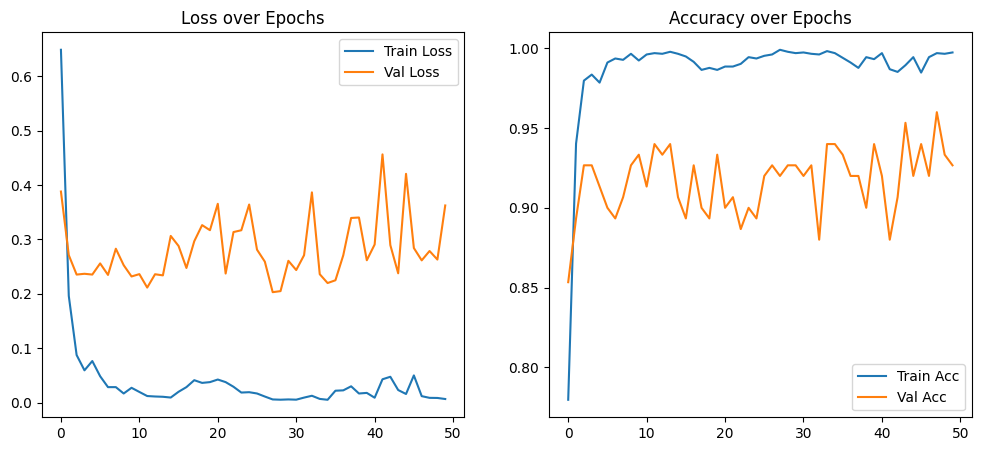

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()

# 12. Evaluation

Classification Report
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00        25
       glass       0.89      0.96      0.92        25
       metal       0.92      0.96      0.94        25
       paper       1.00      1.00      1.00        25
     plastic       0.79      0.88      0.83        25
       trash       1.00      0.76      0.86        25

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



<Figure size 800x600 with 0 Axes>

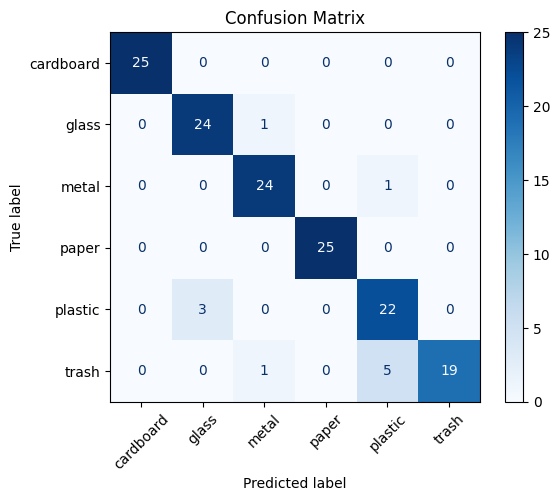

In [12]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report")
print(classification_report(all_labels, all_preds, target_names=list(cat_dict.values())))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(cat_dict.values()))

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# 13. Inference

/home/syahputra/miniconda3/envs/yolo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/syahputra/miniconda3/envs/yolo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


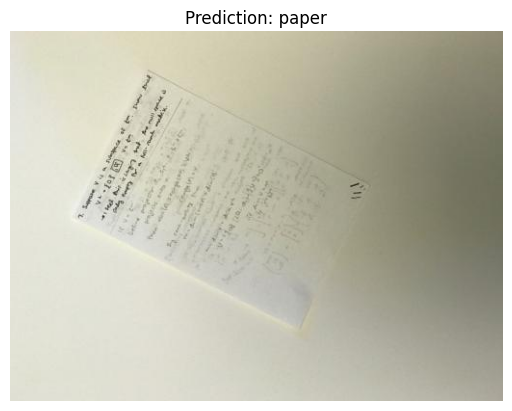

Predicted Class: paper


In [13]:
def predict_image(image_path, model, transform, class_dict):
    model.eval()

    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    img_pil = transforms.ToPILImage()(image)
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = class_dict[predicted.item()]
    
    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 6)
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)

test_image_path = 'dataset/TrashType_Image_Dataset/val/paper/paper_453.jpg'

predicted = predict_image(test_image_path, model, data_transforms['val'], cat_dict)
print(f"Predicted Class: {predicted}")

